# Usando Regressão Logística, Árvores de Decisão e Boosting para predição da eleição de deputados

* Imports gerais
* Modelos
* Métricas de avaliação

In [1]:
%%capture
!pip install imblearn scipy sklearn numpy

In [2]:
%%capture
# coding: utf-8
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
from scipy.stats import normaltest
from sklearn.utils import as_float_array
from sklearn.preprocessing import scale, MinMaxScaler

try:
  from google.colab import files, drive
  drive.mount('/content/drive')
except:
  pass

In [3]:
%%capture
from imblearn.over_sampling import RandomOverSampler as ROS
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.svm import LinearSVC as LSVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN

In [4]:
%%capture
from sklearn.metrics import accuracy_score, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve, ShuffleSplit

## Classes auxiliares

Além dos imports feitos, farei também alguns que me auxiliarão a plotar os resultados  das métricas de cada classificador.

In [5]:
class MetricScores():
  def __init__(self, y_teste):
    self.y_teste = y_teste
    self.reset_df()
    
  def reset_df(self):
    colunas = ["Classifier", "Precision", "Recall", "Accuracy", "F-Score"]
    dic = dict((k, []) for k in colunas)
    self.metric_df = pd.DataFrame(dic)
    
  def get_df(self):
    return self.metric_df
    
  def insert_prediction(self, classifier, predicao):
    precision = precision_score(self.y_teste, predicao)
    recall = recall_score(self.y_teste, predicao)
    accuracy = accuracy_score(self.y_teste, predicao)
    fscore = f1_score(self.y_teste, predicao)
    
    new_row = {
        "Accuracy": accuracy, "Classifier": classifier,
        "F-Score": fscore, "Precision": precision, "Recall": recall
    }
    
    self.metric_df.loc[1 + self.metric_df.shape[0]] = new_row

## Import dos dados

Tentamos importar os dados a partir do Google Drive, já que está sendo feito no Google Colaboratory. Caso não seja possível, importa-se os dados a partir da pasta local.

In [6]:
try:
  drv = 'drive/My Drive/CDP/'
  treino = pd.read_csv(drv + 'train_cat.csv')
  teste = pd.read_csv(drv + 'test_cat.csv')
except:
  treino = pd.read_csv('train_cat.csv')
  teste = pd.read_csv('test_cat.csv')

## Análise dos dados
Como analisaremos os dados de treino, é necessário criar funções que sejam reutilizáveis, para permitir que o mesmo procedimento seja realizado em novas etapas do código. Inicialmente, analisaremos a distribuição das variáveis numéricas com a função `analisa_numericas`, aplicando a normalização nos casos necessários, vistos posteriormente.

Além dos gráficos, será feita uma verificação matemática para gerar um array no qual serão definidas as variáveis que devem ser normalizadas nos dados de treino e de teste: 
considera-se a hipótese de que o array segue uma distribuição normal e define-se um limite `alpha=0.0001` ; caso o resultado do teste de normalidade for menor que alpha, a hipótese de seguir a distribuição normal é rejeitada, isto é, os dados não seguem uma distribuição normal.

In [7]:
# @hidden_cell
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    # Função importada dos exemplos do SKLearn
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(u"Training examples")
    plt.ylabel(u"Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label=u"Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label=u"Cross-validation score")

    plt.legend(loc="best")
    return plt

In [8]:
# @hidden_cell
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # Função importada dos exemplos do SKLearn
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel(u'True label')
    plt.xlabel(u'Predicted label')
    plt.tight_layout()

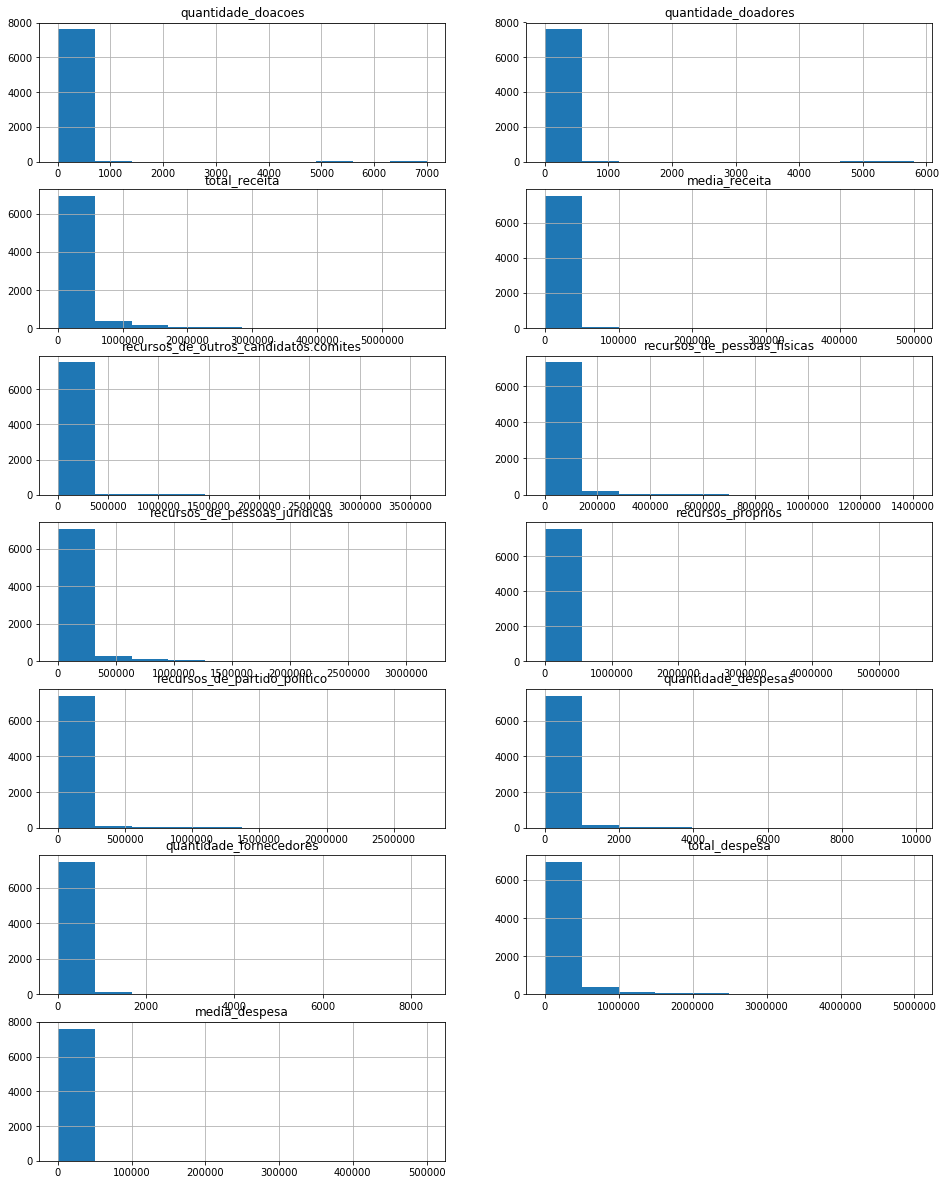

In [9]:
def is_numerico(coluna):
  valor = coluna.ravel()[0]
  numericos = [np.float64, np.float32, np.int64]
  for n in numericos:
    if isinstance(valor, n):
      return True
  return False
  
  
def analisa_numericas(df):
  plt.figure(figsize=(16,24))
  plt.title('Análise das variáveis')

  col_numericas = []
  col_nao_normais = []
  alpha = 1e-3
  
  for coluna in list(df):
    if is_numerico(df[coluna]) and coluna != "ano" and coluna != "sequencial_candidato":
      col_numericas.append(coluna)
      if normaltest(df[coluna])[1] < alpha:
        col_nao_normais.append(coluna)
        
  for i in range(len(col_numericas)):
    coluna = col_numericas[i]
    plt.subplot(round(len(col_numericas)/2.0)+1, 2, i+1)
    plt.title(coluna)
    df[coluna].hist()
  plt.show()
  
  return col_nao_normais
  
colunas = analisa_numericas(treino)

## Manipulação dos Dados

A partir da análise dos gráficos acima, podemos identificar as colunas numéricas que possuem seus dados normalizados, e por isso criaremos a função `normaliza_dados`,  que normaliza todas as colunas recebidas e, ao fim, repete a análise gráfica feita acima.

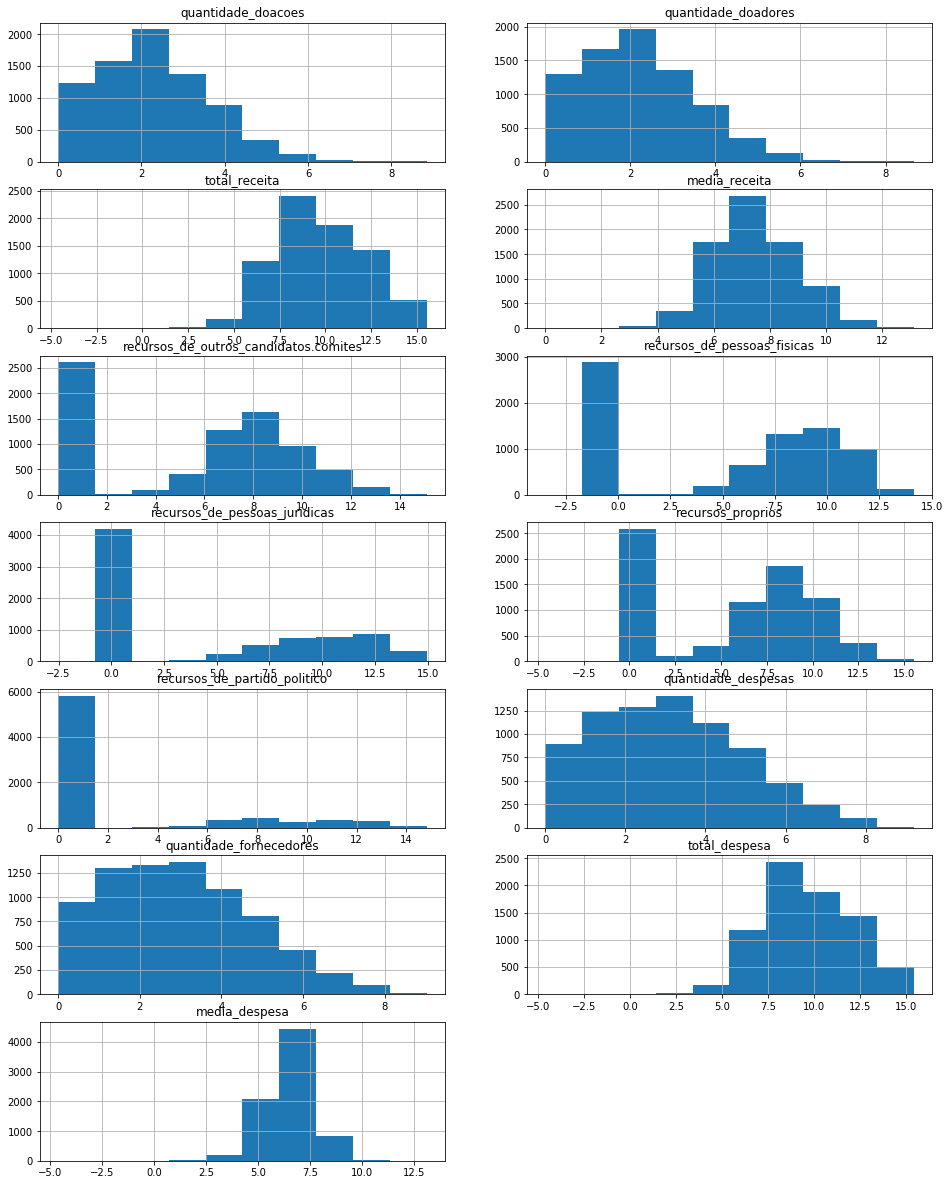

In [10]:
def normaliza_dados(df, colunas, analisa=True):
  for col in colunas:
    temp = df[col][:].apply(np.log).values
    temp[temp == np.inf] = 0
    temp[temp == -np.inf] = 0
    temp[temp == np.nan] = 0
    df[col] = temp
  if (analisa):
    analisa_numericas(df)
    
  return df

treino = normaliza_dados(treino, colunas)
teste = normaliza_dados(teste, colunas, analisa = False)

Assim como no lab anterior, iremos descartar a coluna com os nomes dos deputados por não fazer sentido que o nome beneficie ou prejudique a eleição de um deputado.

In [11]:
try:
  treino = treino.drop('ocupacao', axis=1)
  teste = teste.drop('ocupacao', axis=1)
  treino = treino.drop('nome', axis=1)
  teste = teste.drop('nome', axis=1)
except:
  pass

Em seguida, transformamos todas as colunas de fatores em variáveis dummy

In [12]:
def transforma_fatores(df):
  fatores = ['ano', 'uf', 'partido', 'cargo', 'sexo', 'estado_civil']
  for fator in fatores:
    df = pd.concat([df, pd.get_dummies(df[fator])], axis=1)
    df = df.drop(fator, axis=1)
  return df

treino = transforma_fatores(treino)
teste = transforma_fatores(teste)

Como a escolaridade é um fator que, quanto maior, mais impacto, a codificamos de uma forma diferente, seguindo a função abaixo.

In [13]:
def codifica(df, col_nome, mapa):
  nova_coluna = []

  for i, row in df.iterrows():
    nova_coluna.append(mapa[row[col_nome]])

  df[col_nome] = nova_coluna
  return df

def codifica_escolaridade(df):
  niv_escolaridade = {'LÊ E ESCREVE': 0, 'ENSINO FUNDAMENTAL INCOMPLETO': 1,
                      'ENSINO FUNDAMENTAL COMPLETO': 2,
                      'ENSINO MÉDIO INCOMPLETO': 3, 'ENSINO MÉDIO COMPLETO': 4,
                      'SUPERIOR INCOMPLETO': 5, 'SUPERIOR COMPLETO': 6 }
  return codifica(df, 'grau', niv_escolaridade)

def codifica_situacao(df):
  situacao = { 'eleito': 1, 'nao_eleito': 0 }
  return codifica(df, 'situacao', situacao)

treino = codifica_situacao(codifica_escolaridade(treino))
teste = codifica_escolaridade(teste)

### Padronização

Antes de iniciar o treino, é necessário padronizar os dados entre o conjunto de treino e de testes:

In [14]:
def append_dummy_zeros(dataframe, nome_coluna):
  dataframe[nome_coluna] = pd.Series([0 for i in range(len(dataframe))])
  return dataframe

for key in teste.keys():
  try:
    treino[key]
  except:
    treino = append_dummy_zeros(treino, key)

for key in treino.keys():
  try:
    teste[key]
  except:
    if (key != 'votos'):
      teste = append_dummy_zeros(teste, key)

## Treinando os modelos

Para o treino das árvores, fazemos um hold-out 70/30 para dividir o conjunto de dados entre treino e teste, possibilitando a identificação dos melhores hiper-parâmetros.

In [15]:
treino.head()

,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,...,PV,DEPUTADO FEDERAL,FEMININO,MASCULINO,CASADO(A),DIVORCIADO(A),SEPARADO(A) JUDICIALMENTE,SOLTEIRO(A),VIÚVO(A),2014
0,10001,1.791759,1.791759,9.717158,7.925400,0.000000,9.104980,8.748305,7.170120,0.0,...,0,1,0,1,1,0,0,0,0,0
1,10002,2.564949,2.564949,10.035656,7.470708,8.798606,9.615805,6.907755,5.303305,0.0,...,0,1,1,0,0,0,0,1,0,0
2,10002,2.833213,2.772589,11.971115,9.137901,7.718685,10.438518,11.038445,10.993732,0.0,...,0,1,1,0,0,0,0,0,1,0
3,10002,1.791759,1.791759,8.006741,6.214988,0.000000,7.047517,7.004083,6.620073,0.0,...,0,1,0,1,1,0,0,0,0,0
4,10003,3.871201,3.871201,11.693746,7.822545,0.000000,10.837186,0.000000,11.141021,0.0,...,0,1,0,1,1,0,0,0,0,0


In [16]:
x, y = treino.drop('situacao', axis=1), treino['situacao']

Inicialmente, como pede na questão 1 do exercício, precisamos verificar se existe desbalanceamento nos dados:

1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (10 pt.)

Para verificar se existe ou não desbalanceamento, verificaremos o plot da coluna y dos dados de treino:

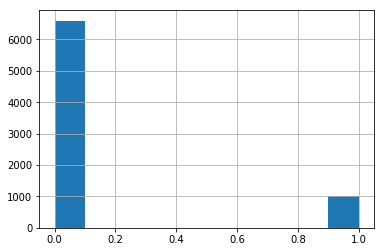

In [17]:
y.hist()

Como é possível ver no gráfico acima, existe muito mais dados de deputados não eleitos do que de deputados eleitos. Para tratar esse problema existem duas possíveis técnicas: _undersampling_ e _oversampling_. O _undersampling_ consiste em reduzir a quantidade de amostras da categoria mais frequente à ponto de ambas categorias ficarem com quantidade similar. O _oversampling_ faz justamente o contrário: seleciona amostras aleatórias dos dados que tem menor frequência e adiciona duplicatas nos dados, tentando igualar a frequência das classes.

Como retirar dados parece ser pior do que adicionar novos dados, a estratégia que eu escolhi é o oversampling:

(array([6596.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6596.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

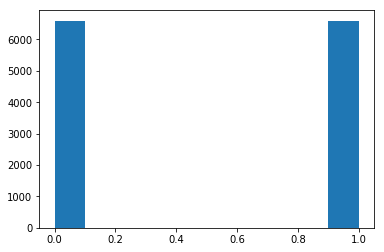

In [18]:
ros = ROS(random_state=71)
x_res, y_res = ros.fit_resample(x, y)
plt.hist(y_res)

In [19]:
x_res_df = pd.DataFrame(x_res)
x_res_df.columns = x.columns

In [20]:
x, y = x_res_df, y_res
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.3)
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=0)
resultados = MetricScores(y_teste)

In [21]:
seq = "sequencial_candidato"

### Treinando a Regressão Logística

Para a regressão logística, definiremos alguns parâmetros para tunar. São eles:

* A penalidade C, que dita a força da regularização
* O número máximo de iterações

In [22]:
c = [0.1, 0.25, 0.35, 0.50, 0.75, 1, 3, 5, 10, 25]
maxiter = [25, 50, 100, 150, 200, 300]
iteracoes_logistica = [c, maxiter]

Em seguida, tunamos o modelo com os parâmetros definidos acima

In [23]:
best_logistica = None
for ci, m in itertools.product(*iteracoes_logistica):
  logistica = LogReg(C = ci, max_iter = m, verbose=1, n_jobs = -1)
  logistica.fit(x_treino.drop(seq, axis=1), y_treino)
  pred = logistica.predict(x_teste.drop(seq, axis=1))
  fscore = f1_score(y_teste, pred)
  
  if (best_logistica == None or best_logistica[1] < fscore):
    best_logistica = [(ci, m), fscore, pred]

/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

Mesmo já tendo o fscore do melhor modelo, adicionamos e calculamos as métricas deste modelo na tabela de resultados, que servirá para comparação futura e escolha do melhor modelo - que será usado na submissão.

In [24]:
resultados.insert_prediction("Regressão Logística", best_logistica[2])
resultados.get_df().head()

,Accuracy,Classifier,F-Score,Precision,Recall
1,0.923951,Regressão Logística,0.926135,0.890094,0.965217


### Treinando Árvores de Decisão

Para treinar as árvores, configuramos alguns parâmetros e selecionamos os que se desempenham melhor:

* Número mínimo de elementos por folha, entre 1, 5, 10, 15, 20, 30, 50, 75, 100.
* Profundidade máxima, entre 1, 5, 10, 15, 25, 30, 50 ou sem limite.
* Número máximo de folhas, entre 50, 40, 30, 20, 10, 5 ou sem limite.
* Número máximo de features, escolhido por sqrt, log2 ou sem limite máximo.
* Número mínimo de elementos ao dividir um nó, entre 2, 5, 10, 15, 20, 25, 30.

In [25]:
# @hidden_cell
min_elements_leaf = [1, 5, 10, 15, 20, 30, 50, 75, 100]
min_split = [2, 5, 10, 15, 20, 25, 30]
max_depth = [1, 5, 10, 15, 25, 30, 50, None]
max_leafs = [50, 40, 30, 20, 10, 5, None]
max_features = ['sqrt', 'log2', None]

iteracao = [min_elements_leaf, max_depth, max_leafs, max_features, min_split]

Em seguida, tendo definidos os possíveis valores dos hiper-parâmetros, podemos então treinar diferentes árvores com esses parâmetros e verificar qual o melhor entre eles:

In [ ]:
best_tree = None
for a, b, c, d, e in itertools.product(*iteracao):
  tree = DTC(max_depth=b, min_samples_leaf=a, max_leaf_nodes=c, max_features=d, min_samples_split=e)
  tree.fit(x_treino.drop(seq, axis=1), y_treino)
  pred = tree.predict(x_teste.drop(seq, axis=1))
  fscore = f1_score(y_teste, pred)
  if (best_tree == None or fscore > best_tree[1]):
    best_tree = [(a,b,c,d,e), fscore, pred]

In [ ]:
# @hidden_cell
estimator = DTC(
    max_depth=best_tree[0][1],
    min_samples_leaf=best_tree[0][0],
    max_leaf_nodes=best_tree[0][2],
    max_features=best_tree[0][3],
    min_samples_split=best_tree[0][4]
)
title = 'Curva de Aprendizado da Decision Tree com parametros tunados'
plot_learning_curve(estimator, title, x.drop(seq, axis=1), y, cv=cv, n_jobs=-1)

estimator = DTC()
title = 'Curva de Aprendizado da Decision Tree sem parametros tunados'
plot_learning_curve(estimator, title, x.drop(seq, axis=1), y, cv=cv, n_jobs=-1)

Pelo gráfico acima, é possível perceber que sem parâmetros, a decision tree se mantém inalterada em termos de score de treino, mas aumenta pouco em relação ao cross-validation score. Já na decision tree com parâmetros, mesmo que o train score decresça, o cross-validation score aumenta significativamente, indicando melhora no treino. No geral, para a árvore treinada temos que:

In [ ]:
acc = accuracy_score(y_teste, best_tree[2], normalize = False)
prec = precision_score(y_teste, best_tree[2])
recall = recall_score(y_teste, best_tree[2])

resultados.insert_prediction("Árvore de Decisão Tunada", best_tree[2])

arvore_simples = DTC()
arvore_simples.fit(x_treino.drop(seq, axis=1), y_treino)
pred_n = arvore_simples.predict(x_teste.drop(seq, axis=1))

resultados.insert_prediction("Árvore de Decisão Não-Tunada", pred_n)

In [ ]:
resultados.get_df().head()

In [ ]:
# @hidden_cell
def filtra_none(valor):
  if valor is None:
    return "Sem limite maximo"
  return str(valor)
tree_params = [filtra_none(v) for v in best_tree[0]]

print("Os parametros tunados que resultaram no melhor F-Score sao:")
print("Número minimo de elementos por folha: %s," % tree_params[0])
print("Profundidade Maxima: %s," % tree_params[1])
print("Maximo de folhas: %s," % tree_params[2])
print("Maximo de features: %s," % tree_params[3])
print("Manimo de elementos para divisao: %s." % tree_params[4])

Ainda na Árvore de decisão, é possível observarmos o confusion plot, tendo uma noção de quantos foram classificados como falsos positivos ou falsos negativos:

In [ ]:
matriz_arv = confusion_matrix(y_teste, best_tree[2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matriz_arv, classes=[0, 1],
                      title='Matriz de Confusao da Decision Tree')

### Treinando o classificador KNN

Inicialmente, definimos os possíveis valores para os hiper-parâmetros do KNN:

* Número de Vizinhos no conjunto 1, 2, 5, 7, 10, 15, 20, 30.
* Tipo de distância: minkowski ou euclidiana.

In [ ]:
# @hidden_cell
n_neighbors = [1, 2, 5, 7, 10, 15, 20, 30]
distance = [1, 2]

iteracao_knn = [n_neighbors, distance]

Tendo os hiper-parâmetros definidos, identificamos o melhor deles:

In [ ]:
best_knn = None
for a, b in itertools.product(*iteracao_knn):
  knn = KNN(n_neighbors = a, p = b)
  knn.fit(x_treino.drop(seq, axis=1), y_treino)
  pred = knn.predict(x_teste.drop(seq, axis=1))
  fscore = f1_score(y_teste, pred)
  
  if (best_knn == None or best_knn[1] < fscore):
    best_knn = [(a, b), fscore, pred]

In [ ]:
# @hidden_cell
estimator = KNN(n_neighbors=best_knn[0][0], p=best_knn[0][1])
title = 'Curva de Aprendizado do KNN com parametros tunados'
plot_learning_curve(estimator, title, x.drop(seq, axis=1), y, cv=cv, n_jobs=-1)

estimator = KNN()
title = 'Curva de Aprendizado do KNN sem parametros tunados'
plot_learning_curve(estimator, title, x.drop(seq, axis=1), y, cv=cv, n_jobs=-1)

In [ ]:
matriz_knn = confusion_matrix(y_teste, best_knn[2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matriz_arv, classes=[0, 1],
                      title='Matriz de Confusao do KNN')

Diferentemente do que aconteceu nas Árvores de decisão, no KNN o training score se mantém estável ao observar o modelo treinado com os parâmetros tunados. Entretanto, apesar da escala, tanto o KNN treinado quanto o não treinado mantém a mesma faixa de resultados para o cross-validation score, o que demonstra resultados não tão satisfatórios no treino. Ainda assim, podemos ver os resultados do KNN:

In [ ]:
resultados.insert_prediction("KNN Tunado", best_knn[2])

knn_n = KNN()
knn_n.fit(x_treino.drop(seq, axis=1), y_treino)
y_knn = knn_n.predict(x_teste.drop(seq, axis=1))

resultados.insert_prediction("KNN não Tunado", y_knn)

In [ ]:
# @hidden_cell
print("A melhor distancia foi de %d. O p escolhido foi: %d." % best_knn[0])

In [ ]:
resultados.get_df()

### Treinando o AdaBoost

Para treinar o AdaBoost, escolheremos um modelo de classificação fraco: uma árvore de decisão com áltura máxima sendo 1. Isso força a simplicidade do modelo e ajuda o algoritmo de boosting por ser um classificador fraco. Além disso, se define o hiper-parâmetro T, que será o número máximo de estimadores, através do tuning.

In [ ]:
simple = DTC(max_depth=1)
Ts = [1, 5, 15, 30, 50, 75, 100, 150, 200, 300]
algorithms = ['SAMME', 'SAMME.R']
iteracao_ada = [Ts, algorithms]

In [ ]:
best_ada = None
for t, alg in itertools.product(*iteracao_ada):
  ada = AdaBoostClassifier(simple, n_estimators=t, algorithm=alg)
  ada.fit(x_treino.drop(seq, axis=1), y_treino)
  pred = ada.predict(x_teste.drop(seq, axis=1))
  fscore = f1_score(y_teste, pred)
  
  if (best_ada == None or best_ada[1] < fscore):
    best_ada = [(t, alg), fscore, pred]

In [ ]:
# @hidden_cell
estimator = AdaBoostClassifier(simple,
                               n_estimators=best_ada[0][0],
                               algorithm=best_ada[0][1])
title = 'Curva de Aprendizado do AdaBoost com parametros tunados'
plot_learning_curve(estimator, title, x.drop(seq, axis=1), y, cv=cv, n_jobs=-1)

estimator = AdaBoostClassifier(simple)
title = 'Curva de Aprendizado do AdaBoost sem parametros tunados'
plot_learning_curve(estimator, title, x.drop(seq, axis=1), y, cv=cv, n_jobs=-1)

In [ ]:
acc_ada = accuracy_score(y_teste, best_ada[2], normalize = False)
prec_ada = precision_score(y_teste, best_ada[2])
recall_ada = recall_score(y_teste, best_ada[2])

resultados.insert_prediction("AdaBoost Tunado", best_ada[2])

ada_n = AdaBoostClassifier(simple)
ada_n.fit(x_treino.drop(seq, axis=1), y_treino)
y_ada = ada_n.predict(x_teste.drop(seq, axis=1))

resultados.insert_prediction("AdaBoost nao Tunado", y_ada)

In [ ]:
# @hidden_cell
print("O melhor numero de parametros foi de %d. O algoritmo escolhido foi: %s." % best_ada[0])

In [ ]:
resultados.get_df()

## Stacking

Para implementar o stacking, inicialmente instanciaremos classificadores treinados com todo o conjunto de dados. Em seguida, prediremos o conjunto de testes e faremos um dataframe com as predições de cada um dos classificadores, e o usaremos para obter a predição do conjunto de testes

In [ ]:
stack_df = pd.DataFrame()
stack_df['Decision Tree'] = best_tree[2]
stack_df['KNN'] = best_knn[2]
stack_df['AdaBoost'] = best_ada[2]
stack_df['Logistic Regression'] = best_logistica[2]

In [ ]:
stack_logistic = LogReg(C = best_logistica[0][0], max_iter = best_logistica[0][1], n_jobs = -1)
stack_logistic.fit(x_treino.drop(seq, axis=1), y_treino)
logistic_pred = stack_logistic.predict(x.drop(seq, axis=1))

In [ ]:
stack_tree = DTC(
    max_depth=best_tree[0][1],
    min_samples_leaf=best_tree[0][0],
    max_leaf_nodes=best_tree[0][2],
    max_features=best_tree[0][3],
    min_samples_split=best_tree[0][4]
)
stack_tree.fit(x_treino.drop(seq, axis=1), y_treino)
tree_pred = stack_tree.predict(x.drop(seq, axis=1))

In [ ]:
stack_knn = KNN(n_neighbors=best_knn[0][0], p=best_knn[0][1])
stack_knn.fit(x_treino.drop(seq, axis=1), y_treino)
knn_pred = stack_knn.predict(x.drop(seq, axis=1))

In [ ]:
stack_ada = AdaBoostClassifier(simple,
                               n_estimators=best_ada[0][0],
                               algorithm=best_ada[0][1])
stack_ada.fit(x_treino.drop(seq, axis=1), y_treino)
ada_pred = stack_ada.predict(x.drop(seq, axis=1))

In [ ]:
xstack = pd.DataFrame()
xstack['Decision Tree'] = tree_pred
xstack['KNN'] = knn_pred
xstack['AdaBoost'] = ada_pred
xstack['Logistic Regression'] = logistic_pred

In [ ]:
stacking = DTC()
stacking.fit(stack_df, y_teste)
y_stck = stacking.predict(xstack)

In [ ]:
resultado_stack = MetricScores(y)
resultado_stack.insert_prediction("Stack", y_stck)
resultado_stack.get_df().head()

Por fim, aplicaremos os classificadores ao conjunto de testes, e submeteremos no Kaggle

In [ ]:
teste = teste.drop('situacao', axis=1)
tree_test = stack_tree.predict(teste.drop(seq, axis=1))
ada_test = stack_ada.predict(teste.drop(seq, axis=1))
knn_test = stack_knn.predict(teste.drop(seq, axis=1))
logistic_test = stack_logistic.predict(teste.drop(seq, axis=1))

In [ ]:
teste_stack = pd.DataFrame()
teste_stack['Decision Tree'] = tree_test
teste_stack['KNN'] = knn_test
teste_stack['AdaBoost'] = ada_test
teste_stack['Logistic Regression'] = logistic_test

In [ ]:
final = stacking.predict(teste_stack)

In [ ]:
def save_df(dataframe, valores_preditos):    
  output = pd.DataFrame()
  mapa = { 0: 'nao_eleito', 1: 'eleito'}
  output['ID'] = teste['sequencial_candidato']
  output['Predicted'] = [mapa[v] for v in valores_preditos]
  output.to_csv('submissao.csv', index=False)
  files.download('submissao.csv')

In [ ]:
save_df(teste, final)